## Libraries

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install "xformers>=0.0.26" trl peft accelerate bitsandbytes

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
import sklearn
import seaborn as sns
import re
import umap
import hdbscan
import langid
import torch
import nltk
import dill
import os

from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments, GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
from collections import Counter
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords


# OrcaSlim EDA

In [ ]:
dataset = pd.read_csv('dataset.csv')
n_lines, n_columns = dataset.shape
print("Number of lines:", n_lines)
print("Number of columns:", n_columns)

Number of lines: 1520029<br>
Number of columns: 14

### Aggregated Analysis

In [ ]:
plt.figure(figsize=(5, 4))
plt.bar(dataset['from'].unique(), dataset['from'].value_counts(), color='lightsalmon')
plt.title('Distribution of the "From" Category from Messages')
plt.xlabel('Category')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.show()

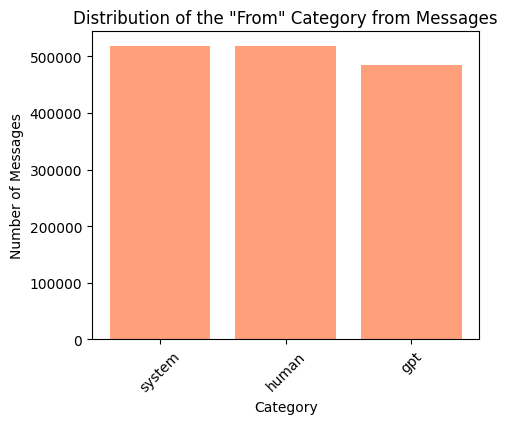

In [ ]:
mean_values = dataset.groupby('from')['message_length'].mean()
plt.figure(figsize=(5, 4))
mean_values.plot(kind='bar', color='yellowgreen')
plt.title('Average Message Lenght per Conversation')
plt.xlabel('Category')
plt.ylabel('Average Message Lenght')
plt.show()

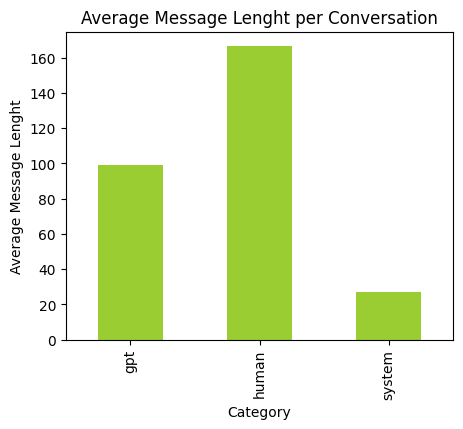

In [ ]:
plt.hist(dataset['message_length'], bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

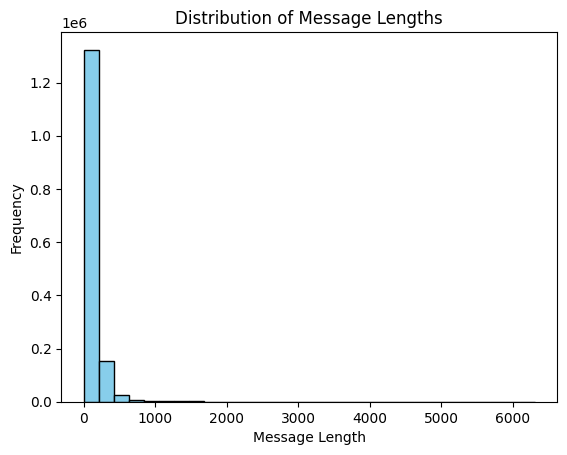

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    temp = dataset[['vocab_length_byid_not_clean', 'vocab_length_byid_no_stopwords', 'vocab_length_byid_no_stopwords_digits']].iloc[:, i]
    sns.histplot(temp.values[::3], bins=50, ax=axes[i], color='pink')
    axes[i].set_title(temp.name)  # Set subplot title to temp.name
    axes[i].set_xlabel('Unique Words Count')
    axes[i].set_ylabel('Frequency of Conversations')

plt.suptitle('Distribution of Vocabulary Sizes across Conversations', fontsize = "x-large")
plt.tight_layout()
plt.show()

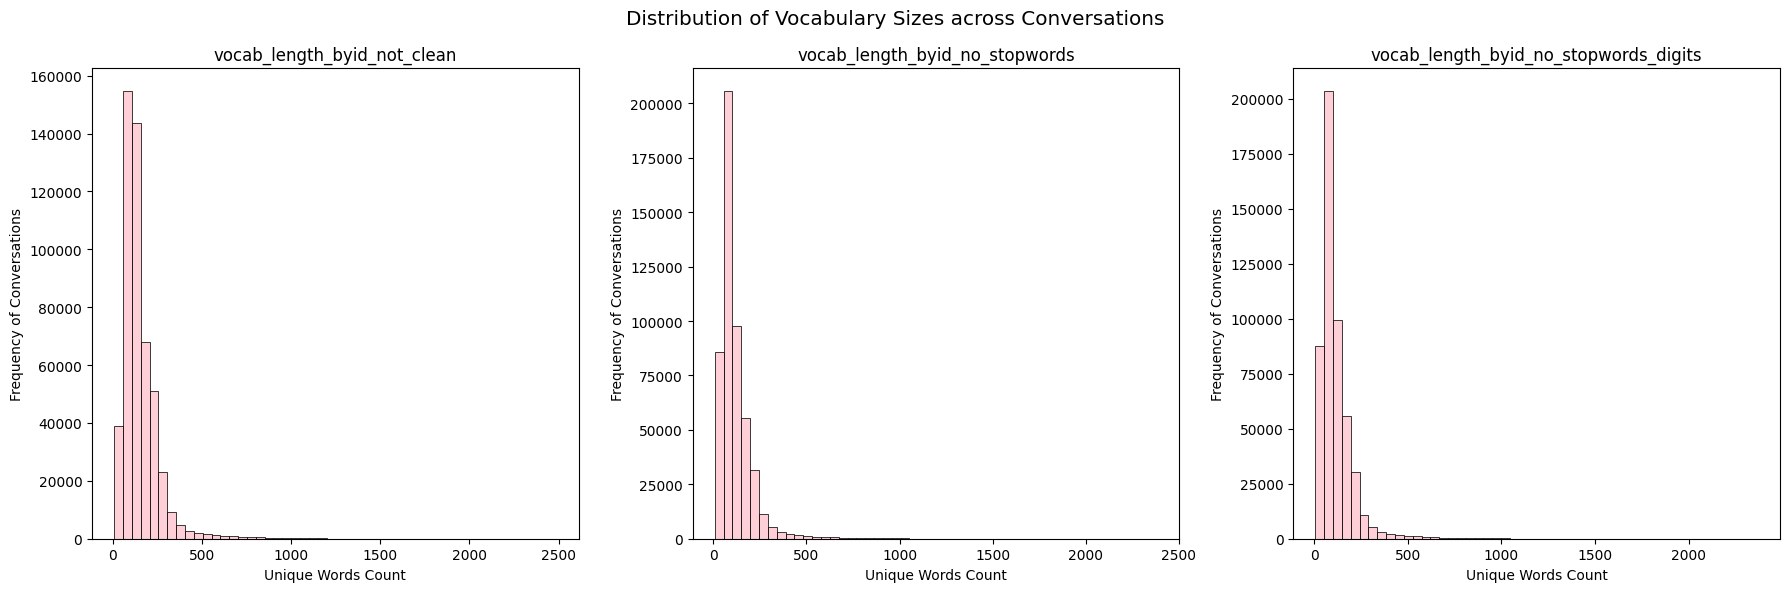

### Analysis based on Sender

In [ ]:
df_gpt = dataset[dataset['from'] == 'gpt']
df_system = dataset[dataset['from'] == 'system']
df_human = dataset[dataset['from'] == 'human']

In [ ]:
df_gpt['Stopwords Number'] = df_gpt['vocab_length_byid_not_clean'] - df_gpt['vocab_length_byid_no_stopwords']
df_system['Stopwords Number'] = df_system['vocab_length_byid_not_clean'] - df_system['vocab_length_byid_no_stopwords']
df_human['Stopwords Number'] = df_human['vocab_length_byid_not_clean'] - df_human['vocab_length_byid_no_stopwords']

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(df_system['Stopwords Number'], bins=30, alpha=0.5, label='System', color='salmon', edgecolor='black')
axs[1].hist(df_gpt['Stopwords Number'], bins=30, alpha=0.5, label='Gpt', color='palegreen', edgecolor='black')
axs[2].hist(df_human['Stopwords Number'], bins=30, alpha=0.5, label='Human', color='slateblue', edgecolor='black')

axs[0].set_title("System's Number of Stopwords")
axs[1].set_title("gpt's Number of Stopwords")
axs[2].set_title("Human's Number of Stopwords")

plt.tight_layout()
plt.show()

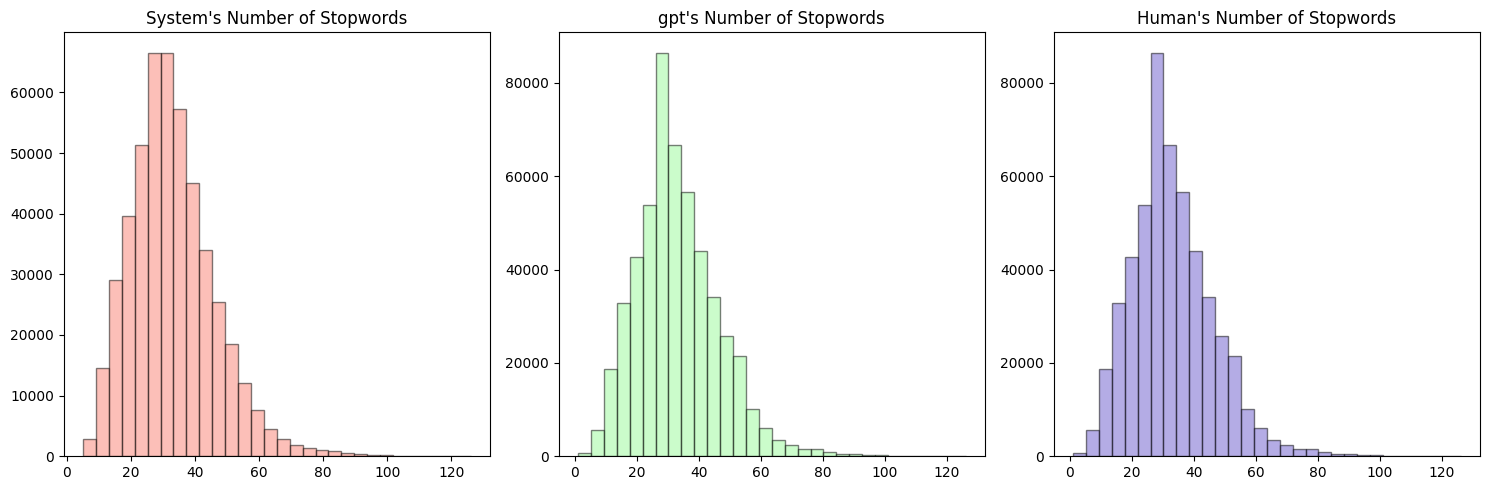

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ['lightcoral', 'lightskyblue']

# Prepare data
labels_gpt = df_gpt['message_count'].value_counts().index
sizes_gpt = df_gpt['message_count'].value_counts().values

labels_system = df_system['message_count'].value_counts().index
sizes_system = df_system['message_count'].value_counts().values

labels_human = df_human['message_count'].value_counts().index
sizes_human = df_human['message_count'].value_counts().values

# Create the circular graphs
axs[0].pie(sizes_gpt, labels=labels_gpt, colors=colors, autopct='%1.2f%%', startangle=45)
axs[1].pie(sizes_system, labels=labels_system, colors=colors, autopct='%1.2f%%', startangle=45)
axs[2].pie(sizes_human, labels=labels_human, colors=colors, autopct='%1.2f%%', startangle=45)

# Define Titles
axs[0].set_title("System's Message Count")
axs[1].set_title("gpt's Message Count")
axs[2].set_title("Human's Message Count")

plt.show()

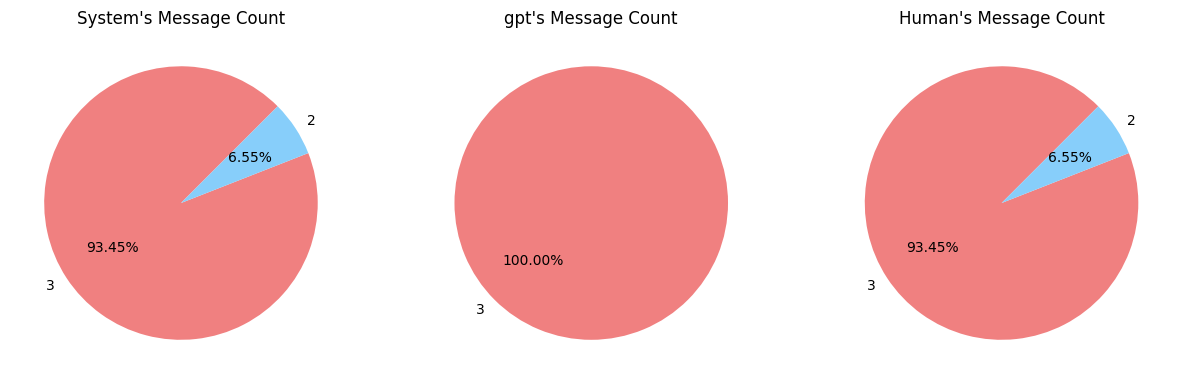

In [ ]:
# Calculation of text length summary statistics

def msg_lenght_stats(data):
    print(f'Mean: {round(data.mean(), 2)} Median: {data.median()} Minimum: {data.min()} Maximum: {data.max()}')
    
print(f'Statistics for gpt {msg_lenght_stats(df_gpt['message_length'])}')
print(f'Statistics for System {msg_lenght_stats(df_system['message_length'])}')
print(f'Statistics for Human {msg_lenght_stats(df_human['message_length'])}')


Statistics for gpt
Mean: 98.95
Median: 63.0
Minimum: 1
Maximum: 1038

Statistics for System
Mean: 27.26
Median: 31.0
Minimum: 12
Maximum: 70

Statistics for Human
Mean: 166.44
Median: 68.0
Minimum: 3
Maximum: 6310



### Additional Analysis on GPT answers

In [ ]:
df_gpt['msg'].fillna('', inplace=True)
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
vectorizer.fit(df_gpt['msg'])
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 83951

In [ ]:
vector_documents = vectorizer.transform(df_gpt['msg'])
common_words = sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])
print('Most common words by the Chatbot:\n')
print('Word -> TF-IDF Score')
for i, (word, score) in enumerate(common_words):
    print("{}: {} -> {}".format(i+1, word, round(score,4)))
    if i == 9:
        break

Most common words by the Chatbot:

Word -> TF-IDF Score<br>
1: victims -> 0.2957<br>
2: murder -> 0.2429<br>
3: suspect -> 0.2276<br>
4: sydney -> 0.227<br>
5: tragic -> 0.2034<br>
6: community -> 0.1611<br>
7: date -> 0.1591<br>
8: crime -> 0.1541<br>
9: alleged -> 0.1335<br>
10: attempted -> 0.1326


### Additional Analysis on System inputs

In [ ]:
df_system['msg'].fillna('', inplace=True)
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(df_system['msg'])
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 77


In [ ]:
vector_documents = vectorizer.transform(df_system['msg'])
common_words = sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])
print('Most common words for the System:\n')
print('Word -> TF-IDF Score')
for i, (word, score) in enumerate(common_words):
    print("{}: {} -> {}".format(i+1, word, round(score,4)))

Most common words by the System:

Word -> TF-IDF Score<br>
1: ai -> 0.4988<br>
2: assistant -> 0.486<br>
3: generate -> 0.3971<br>
4: detailed -> 0.3542<br>
5: task -> 0.2965<br>
6: long -> 0.2926<br>
7: given -> 0.1853<br>
8: answer -> 0.1552


# Preprocess

### Language Detection and Filtering

#### Helper Functions

In [ ]:
def detect_language(text):
    language, confidence = langid.classify(text)
    return language, confidence

def custom_tokenizer(text):
    pattern = r'\b\w\w+\b'  # Matches alphanumeric tokens with 2 or more characters
    tokens = re.findall(pattern, text.lower())  # Find all tokens and convert to lowercase
    return tokens

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english", tokenizer = custom_tokenizer) 
    t = count.fit_transform(documents)
    t = csr_matrix(t) # Convert count matrix to CSR format for memory efficiency
    sum_t = np.array(t.sum(axis=0)).squeeze() # Calculate document frequencies (df) directly from the sparse count matrix
    idf = np.log(np.divide(m, sum_t)) # Calculate inverse document frequencies (idf) using document frequencies (df)
    tf_idf = t.multiply(idf) # Calculate TF-IDF directly from the sparse count matrix and idf

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    if not isinstance(tf_idf, csr_matrix):
        tf_idf = tf_idf.tocsr()
        
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    
    top_n_words = {}
    for label in np.unique(labels):
        topic_indices = np.where(docs_per_topic.Topic == label)[0]
        row_sum = tf_idf[topic_indices].sum(axis=0)
        row_sum = np.array(row_sum).flatten()
        indices = np.argpartition(row_sum, -n)[-n:]
        top_words = [(words[j], row_sum[j]) for j in indices[np.argsort(-row_sum[indices])]]
        top_n_words[label] = top_words
    
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic']).ADJUSTED_COMMENT.count().reset_index(name='Size').sort_values("Size", ascending=False))
    return topic_sizes

In [ ]:
# Detect language on GPT Answers and remove non-english
df_gpt['msg'] = df_gpt['msg'].fillna('')
df_gpt[['language', 'confidence']] = df_gpt['msg'].apply(lambda x: detect_language(str(x))).apply(pd.Series)
label_count = Counter(df_gpt['language'])
df_gpt_en = df_gpt[df_gpt['language'] == 'en']

label_count

Counter({ <br>'en': 478807, <br>
         'fi': 1365, <br>
         'fr': 4058, <br>
         'af': 594, <br>
         'it': 1959, <br>
         'tr': 2879, <br>
         'cs': 915, <br>
         'no': 483, <br>
         'nl': 533, <br>
         'da': 905, <br>
         'de': 1978, <br> 
         'Unknown': 597, <br>
       ... <br>
         'pa': 24, <br>
         'hi': 54, <br>
         'mk': 9, <br>
         'el': 5, <br>
         'ko': 8, <br>
         'zh-cn': 22})

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
df_gpt_en.reset_index(drop=True, inplace=True)
embeddings = model.encode(df_gpt_en['msg'], show_progress_bar=True)

### UMAP and DBSCAN

UMAP is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. One advantage of UMAP for this is that it doesn’t require us to reduce to only two dimensions – we can reduce up to 10 dimensions, since the goal is to cluster, not visualize (altough in this dataset we reduced down to 3D for visualization), and the performance cost with UMAP is minimal. 

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)

Altough we ran with min_cluster_size up to 2000, for this presentation we'll show smaller, but more specialized clusters. We found 200 to be a good number for that.

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
docs_df = pd.DataFrame(df_gpt_en['msg'])
docs_df = docs_df.rename(columns={'msg': 'ADJUSTED_COMMENT'})
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df

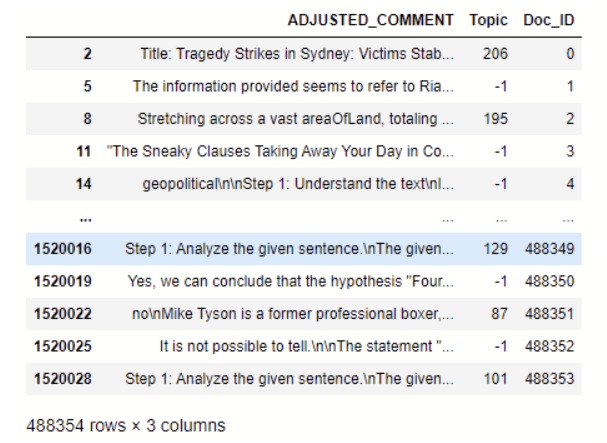

We'll obtain the tf_idf and the count of the amount of words that can be related to each topic. Then, we'll extract the top words and the topic sizes in order to assess basic information obtained with the clustering.

In [ ]:
tf_idf, count = c_tf_idf(docs_df.ADJUSTED_COMMENT.values, m=len(docs_df))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_df, n=5)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

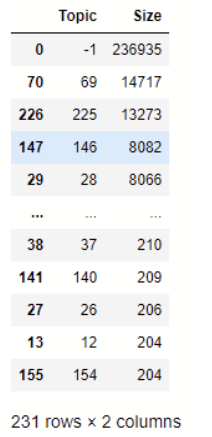

We can see that the we have lots of "outliers" and that the first topics of the table are super populated! We can also see that there are a lot of smaller clusters. Taking into account what we've learned until now about OrcaSlim, it makes sense to be like that, since it's a dataset with a bunch of generic conversations between users and an LLM.

In [ ]:
data ={}
for key, value in top_n_words.items():
    temp = []
    for i in range(len(value)):
        temp.append(value[i][0])
    data.update({str(key): temp})

pd.DataFrame(data)

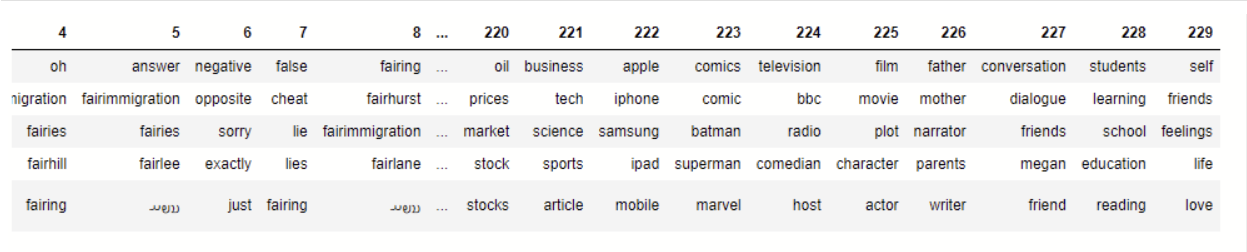

Wow! Super interesting how most of the words seem to fall on such closely related topics! We would say an interesting one is, for example,"bbc" being inserted in a cluster related to radio and television shows! We can therefore conclude that UMAP is a super usefull, and fast, approach for clustering!

In [ ]:
result = pd.DataFrame(umap_embeddings, columns=['x', 'y', 'z'])
result['labels'] = cluster.labels_
filtered_result = result[~result['labels'].isin([-1, 1, 2, 5])]
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d') # Create a 3D scatter plot without outliers
# Plot the data points with cluster labels
scatter = ax.scatter(filtered_result['x'], filtered_result['y'], filtered_result['z'], c=filtered_result['labels'], cmap='viridis', marker='o')

ax.set_xlabel('UMAP1'); ax.set_ylabel('UMAP2'); ax.set_zlabel('UMAP3') # Set labels for the axes
ax.set_title('3D UMAP Projection with Clusters (Outliers Removed)') # Title for the plot
cbar = plt.colorbar(scatter, ax=ax, pad=0.1); cbar.set_label('Cluster Labels') # Add a color bar to show cluster labels
plt.show() # Show the plot

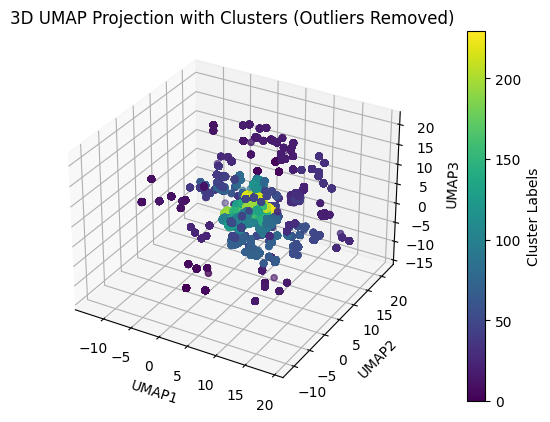

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = filtered_result.loc[result.labels == -1, :]
clustered = filtered_result.loc[filtered_result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=100, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=100, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

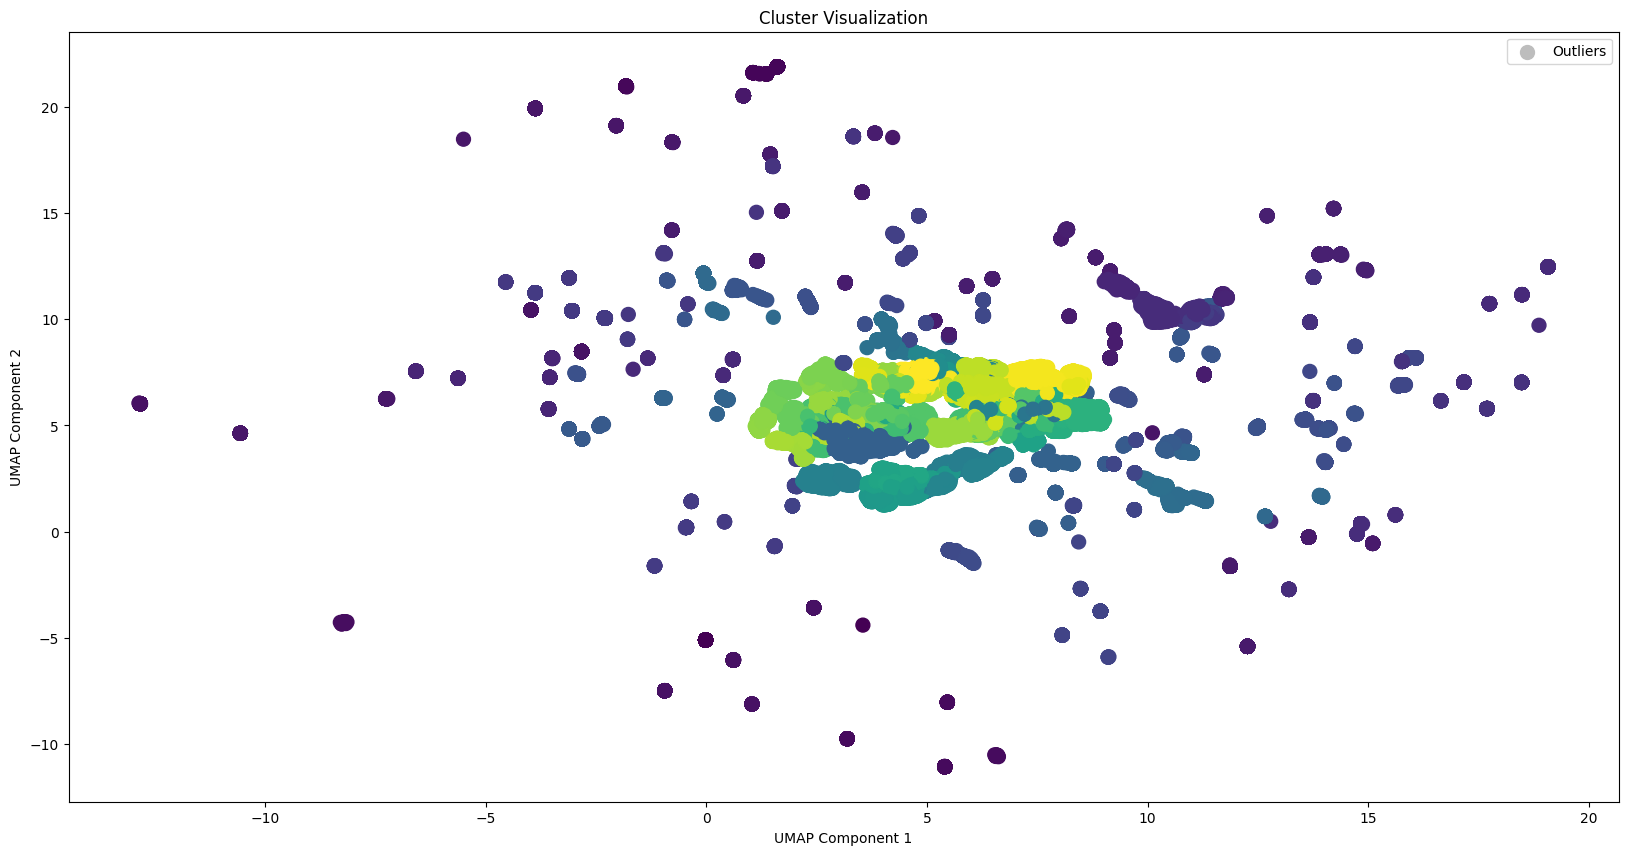

With this plots we can conclude what we already knew: our dataset is super generalized, as it is demonstrated with the clusters being so close to eachother. It is important to denote that UMAP is extremely fast compared to algorithms such as t-sne, which for handling such a big dataset like OrcaSlim, became super useful.

### LDA

In [ ]:
def extract_numbers_and_special_chars(text):
    if isinstance(text, str):
        return re.findall(r'[0-9\W]+', text)
    else:
        return ""
# We only want english messages
df_english = df_gpt.loc[df_gpt['language'] == 'en']
df_english['msg'] = df_english['msg'].dropna()
df_english['language'] = df_english['msg'].apply(extract_numbers_and_special_chars)
df_english = df_gpt.loc[df_gpt['language'] == 'en']
documents_train, documents_test = train_test_split(df_english['msg'], test_size=0.3, random_state=42)

documents_train = documents_train.dropna()
documents_test = documents_test.dropna()

print('Trainnig docs number:', len(documents_train))
print('Testing docs number:', len(documents_test))

Trainnig docs number: 341790<br>
Testing docs number: 146488


In [ ]:
vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.6)
vector_documents_train = vectorizer.fit_transform(documents_train)
lda = LatentDirichletAllocation(n_components=40, verbose=1, learning_method='online', max_iter=10)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 10<br>
iteration: 2 of max_iter: 10<br>
iteration: 3 of max_iter: 10<br>
iteration: 4 of max_iter: 10<br>
iteration: 5 of max_iter: 10<br>
iteration: 6 of max_iter: 10<br>
iteration: 7 of max_iter: 10<br>
iteration: 8 of max_iter: 10<br>
iteration: 9 of max_iter: 10<br>
iteration: 10 of max_iter: 10


In [ ]:
vector_documents_test = vectorizer.transform(documents_test)
lda.perplexity(vector_documents_test)

35414.28550742501

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

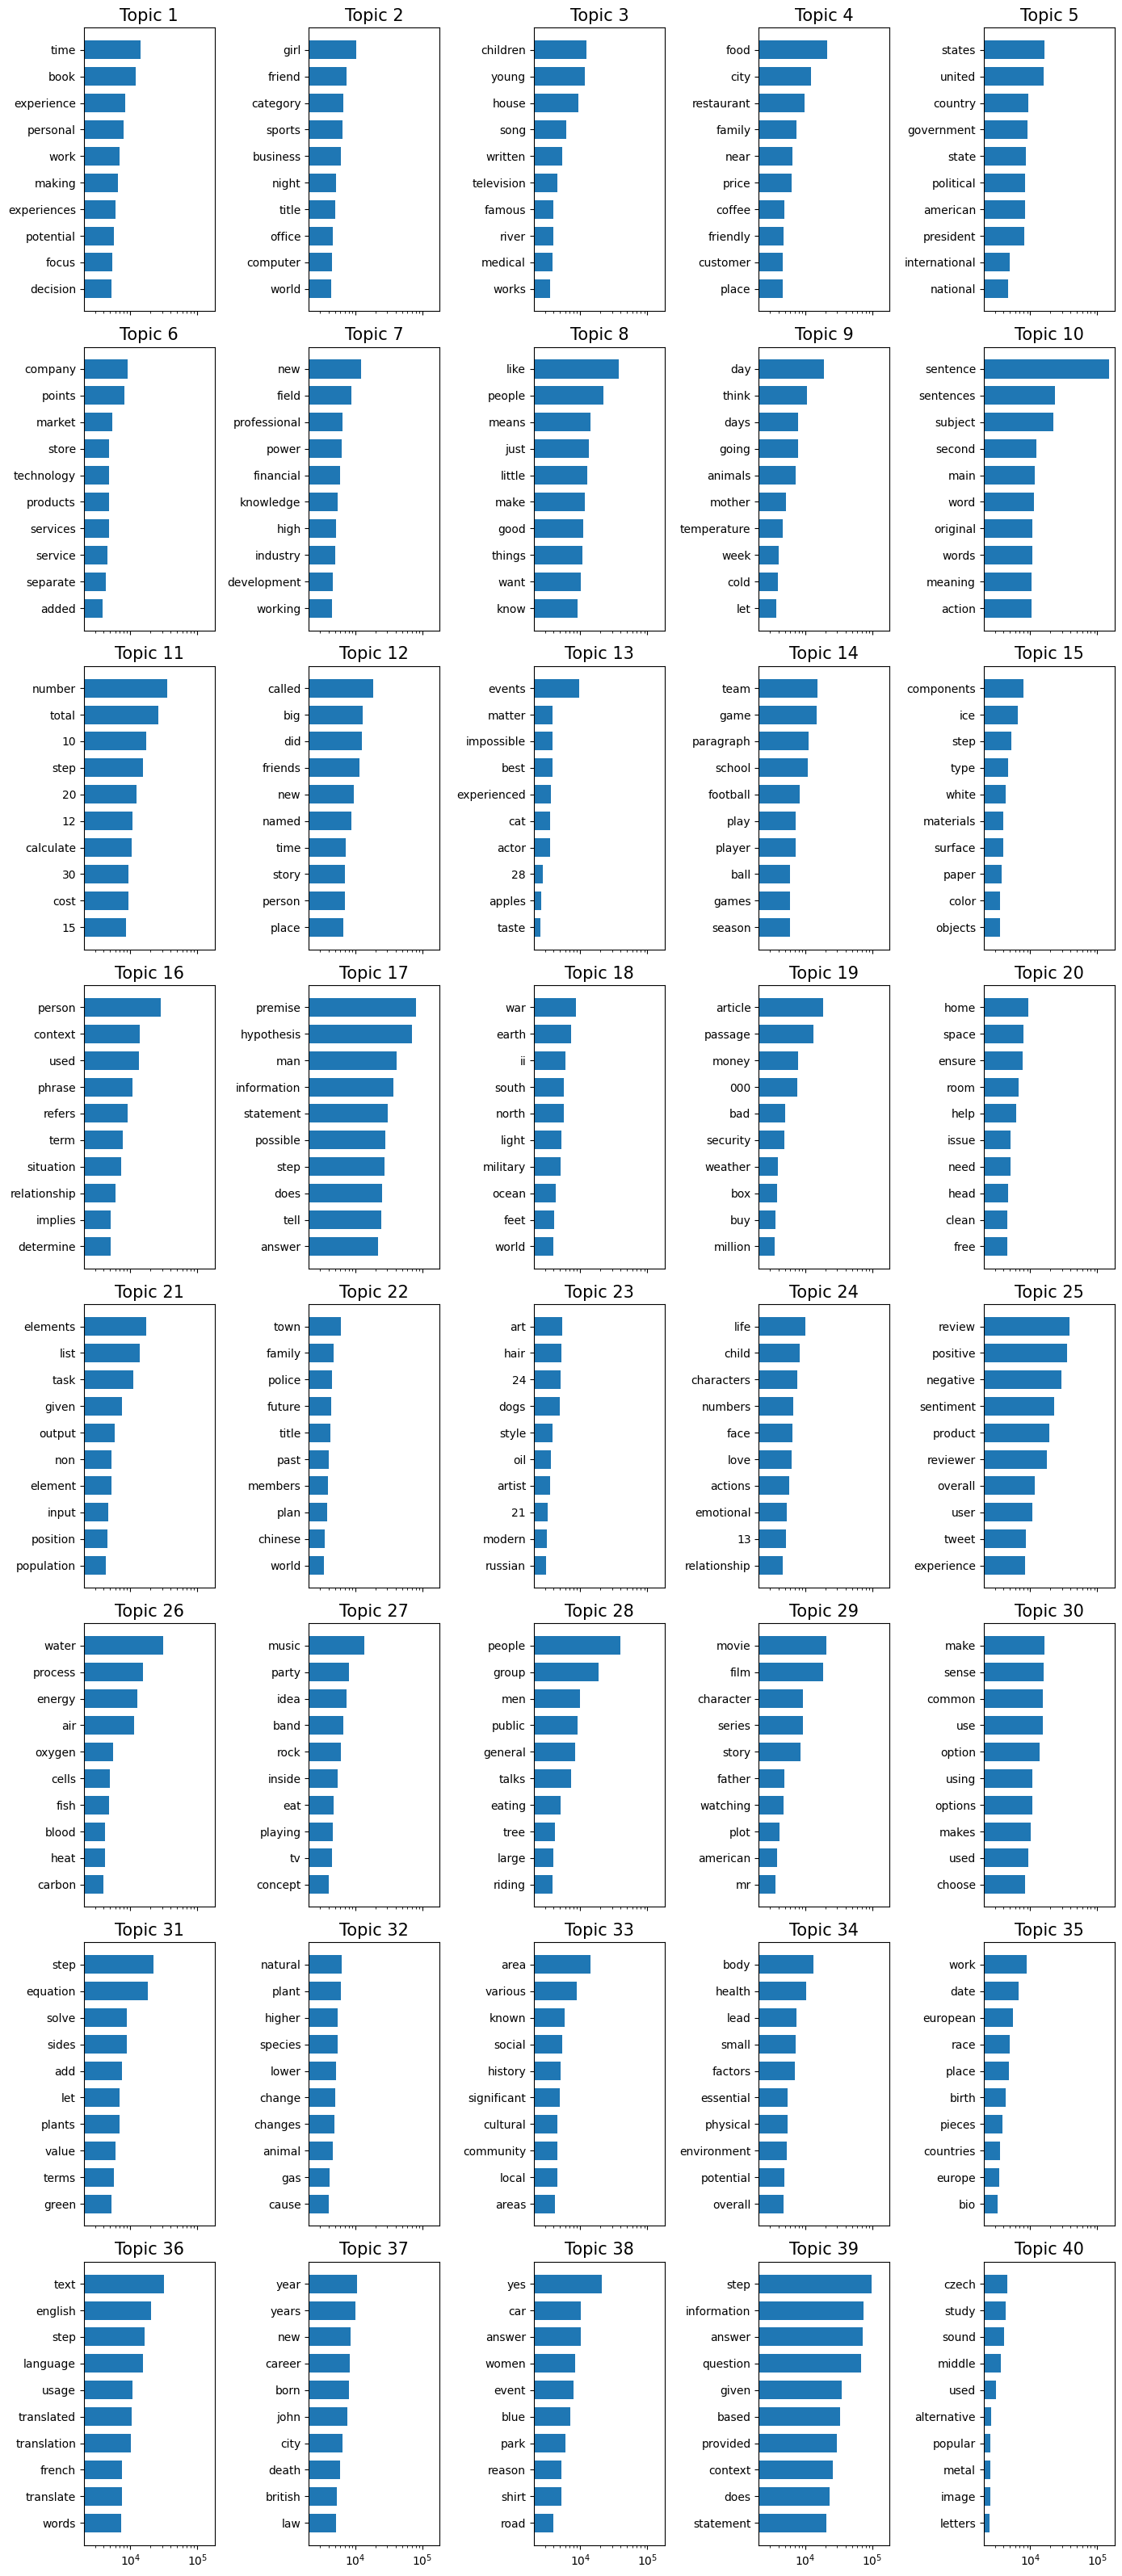()


# Fine-Tuning

### Mistral 7B Training

In [ ]:
max_seq_length = 2048 
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage

fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-2b-bnb-4bit"] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit", max_seq_length = max_seq_length, dtype = dtype,
    load_in_4bit = load_in_4bit) # EXTRA POTENTIAL VAR.: token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0.1, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "mistral", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

In [ ]:
dataset = dataset[df_gpt['language'] == 'en'].reset_index(drop=True)

third_dataset_size = len(dataset)

dataset = dataset.select(range(third_dataset_size))
dataset = dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
messages = [{"from": "human", "value": "Could you talk in detail about the future of artificial intelligence"},]
inputs = tokenizer.apply_chat_template(
    messages, tokenize = True, add_generation_prompt = True, # Must add for generation
    return_tensors = "pt").to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 30, use_cache = True)
tokenizer.batch_decode(outputs)

["<|im_start|>user\nCould you talk in detail about the future of artificial intelligence<|im_end|> \n<br><|im_start|>assistant\nI'm sorry, I don't understand the question. Could you rephrase it?\n\n<|im_end|>\n\n"]

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        max_steps = 100,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.<br>
6.91 GB of memory reserved.

In [ ]:
trainer_stats = trainer.train()

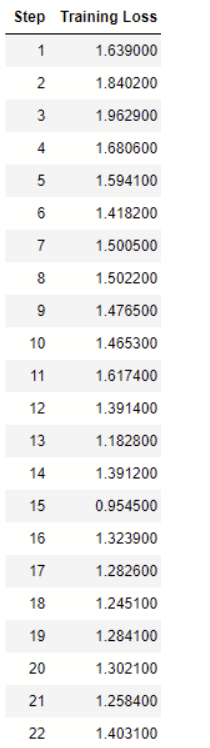

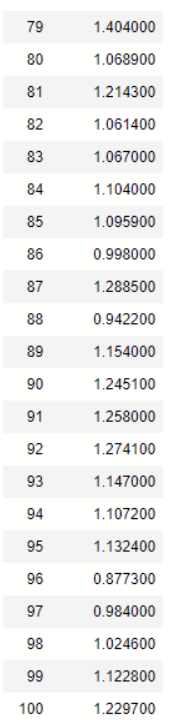

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

349.0214 seconds used for training.<br>
5.82 minutes used for training.<br>
Peak reserved memory = 27.781 GB.<br>
Peak reserved memory for training = 20.871 GB.<br>
Peak reserved memory % of max memory = 70.218 %.<br>
Peak reserved memory for training % of max memory = 52.753 %.


In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [{"from": "human", "value": "Could you talk in detail about the future of artificial intelligence"},]
inputs = tokenizer.apply_chat_template(messages,tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt").to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 1000, use_cache = True)
tokenizer.batch_decode(outputs)

['<|im_start|>user\nCould you talk in detail about the future of artificial intelligence<|im_end|> \n<br><|im_start|>assistant\nThe future of artificial intelligence (AI) is an exciting and rapidly evolving field that holds immense potential for transforming various aspects of our lives. As AI technology continues to advance, we can expect to see significant developments in the coming years.\n\nOne of the key areas where AI is expected to make a significant impact is in the field of healthcare. AI-powered tools and systems are being developed to assist healthcare professionals in diagnosing and treating patients more accurately and efficiently. For example, AI algorithms can analyze medical images and identify patterns that may be difficult for human eyes to detect, leading to more accurate diagnoses and earlier interventions.\n\nIn the field of transportation, AI is being used to develop self-driving cars that can navigate roads safely and efficiently. These cars are equipped with sensors and cameras that allow them to perceive their surroundings and make decisions based on real-time data. This technology has the potential to reduce traffic accidents and congestion, making our roads safer and more efficient.\n\nAI is also being used to develop personalized recommendations and predictions in various fields, such as e-commerce, entertainment, and education. For example, AI algorithms can analyze user behavior and preferences to provide personalized product recommendations or suggest educational materials that are tailored to individual needs.\n\nAs AI technology continues to advance, we can also expect to see more ethical and societal concerns arise. It is important to ensure that AI is developed and used in a responsible and ethical manner, taking into account the potential impact on society and individuals.\n\nIn conclusion, the future of artificial intelligence is bright and full of potential. As AI technology continues to advance, we can expect to see significant developments in various fields, from healthcare to transportation to personalized recommendations. However, it is important to ensure that AI is developed and used in a responsible and ethical manner, taking into account the potential impact on society and individuals.<|im_end|>']

In [ ]:
FastLanguageModel.for_inference(model)

messages = [{"from": "human", "value": "What's the result of x^2=-1?"},]
inputs = tokenizer.apply_chat_template(messages, tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt").to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 1000, use_cache = True)
tokenizer.batch_decode(outputs)

["<|im_start|>user\nWhat's the result of x^2=-1?<|im_end|> \n <br><|im_start|>assistant\nThe result of x^2=-1 is not a real number. In mathematics, the square of a real number cannot be negative.<|im_end|>"]

### Llama 2  13B

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-2-13b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length, dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 128, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0.1, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [{"from": "human", "value": "Could you talk in detail about the future of artificial intelligence"},]
inputs = tokenizer.apply_chat_template(messages, tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt").to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 100, use_cache = True)
tokenizer.batch_decode(outputs)

['<|im_start|>user\nCould you talk in detail about the future of artificial intelligence<|im_end|> <br>\n<|im_start|>assistant\n<|im_start|>and how it will affect our lives?\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_start|>\n<|im_']

In [ ]:
trainer = SFTTrainer(
    model=model,  # Consider using a larger model variant
    tokenizer=tokenizer,
    train_dataset = dataset,
    dataset_text_field="text",
    max_seq_length=512,  # Increased from previous values if applicable
    dataset_num_proc=1,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,  # Increased to simulate larger batches
        warmup_steps=50,  # Longer warmup
        max_steps=1000,  # Longer training duration
        learning_rate=1e-4,  # Lower learning rate for finer adjustments
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=10,  # Less frequent logging for longer runs
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",  # Using a cosine decay schedule for smoother learning rate changes
        seed=3407,
        output_dir="outputs",),)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.<br>
10.799 GB of memory reserved.

In [ ]:
trainer_stats = trainer.train()

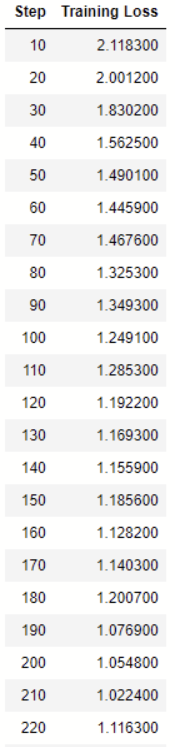

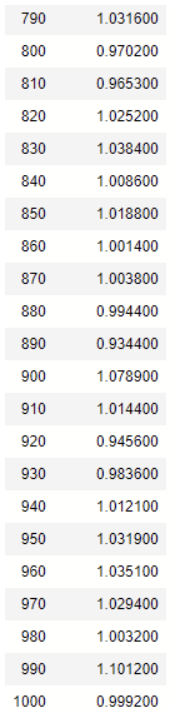

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4245.4939 seconds used for training.<br>
70.76 minutes used for training.<br>
Peak reserved memory = 26.344 GB.<br>
Peak reserved memory for training = 15.545 GB.<br>
Peak reserved memory % of max memory = 66.586 %.<br>
Peak reserved memory for training % of max memory = 39.291 %.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [{"from": "human", "value": "Could you talk in detail about the future of artificial intelligence"},]
inputs = tokenizer.apply_chat_template(messages, tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt").to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 1500, use_cache = True)
tokenizer.batch_decode(outputs)

['<|im_start|>user\nCould you talk in detail about the future of artificial intelligence<|im_end|> \n<br><|im_start|>assistant\nThe future of artificial intelligence is an exciting and rapidly evolving field. As technology advances, so do the capabilities of AI, leading to a wide range of potential applications and implications for society. Some of the key areas of focus for the future of AI include:\n\n1. Machine Learning: Machine learning is a subfield of AI that focuses on the development of algorithms and models that can learn from data and make predictions or decisions. It has already had a significant impact in many industries, such as healthcare, finance, and retail, and is expected to play an even larger role in the future.\n\n2. Natural Language Processing: Natural language processing (NLP) is a subfield of AI that focuses on the development of algorithms and models that can understand and generate human language. This technology is already being used in areas such as chatbots, virtual assistants, and language translation, and is expected to play an increasingly important role in the future.\n\n3. Robotics: Robotics is a field of AI that focuses on the development of machines that can perform tasks typically performed by humans. This technology is already being used in areas such as manufacturing, healthcare, and agriculture, and is expected to play an even larger role in the future.\n\n4. Autonomous Vehicles: Autonomous vehicles are a field of AI that focuses on the development of vehicles that can navigate and operate without human input. This technology is already being used in areas such as self-driving cars, and is expected to play an increasingly important role in the future.\n\n5. Cybersecurity: Cybersecurity is a field of AI that focuses on the development of algorithms and models that can protect against cyber threats. As the number of connected devices and the amount of data being generated continues to increase, the need for effective cybersecurity measures is also expected to grow.\n\nOverall, the future of AI is expected to bring significant changes and advancements in many areas, from healthcare and finance to transportation and cybersecurity. However, it is important to consider the ethical implications of these advancements and ensure that they are developed and used in a responsible and beneficial way.<|im_end|>']

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [{"from": "human", "value": "What's the result of x^2=-1?"},]
inputs = tokenizer.apply_chat_template(messages, tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 1000, use_cache = True)
tokenizer.batch_decode(outputs)

["<|im_start|>user\nWhat's the result of x^2=-1?<|im_end|> \n<br><|im_start|>assistant\nThe result of x^2=-1 is x = ±i, where i is the imaginary unit, which is the square root of -1.<|im_end|>"]